In [261]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
import clip
from sklearn.preprocessing import StandardScaler
import hdbscan
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from IPython.display import display


In [262]:
# Load clothing dataset
clothing_excel_path = "C:/Users/megdy/Desktop/stat 4830/STAT-4830-vllm-project/two_tower/clothing_data.xlsx"
df_items = pd.read_excel(clothing_excel_path)
df_items.drop([df_items.columns[0],"user"], axis=1, inplace=True)

# Load user ratings dataset
ratings_excel_path = "C:/Users/megdy/Desktop/stat 4830/STAT-4830-vllm-project/two_tower/rating_data.xlsx"
df_ratings = pd.read_excel(ratings_excel_path, sheet_name='Copy of Sheet1')
df_ratings.drop([df_ratings.columns[0], "Average"], axis=1, inplace=True)

# Ensure all column names are stripped and lowercased for consistency
df_ratings.columns = df_ratings.columns.str.strip().str.lower()

# Assign implicit rating of 10 for the user who originally liked the item
for idx, row in df_ratings.iterrows():
    liked_user = str(row["user"]).strip().lower()  # Get the user who originally liked the item

    if liked_user in df_ratings.columns:
        df_ratings.at[idx, liked_user] = 10  # Assign rating of 10

# df_ratings is SHORTER, add empty rows (NaNs)
missing_rows = len(df_items) - len(df_ratings)
df_ratings = pd.concat([df_ratings, pd.DataFrame(np.nan, index=range(missing_rows), columns=df_ratings.columns)], ignore_index=True)
df_ratings.index = df_items.index


In [263]:
df_items

,brand,name,description,price
0,Forever 21,Twill Wide-Leg Cargo Pants,A pair of twill pants featuring contrasting to...,24.49
1,gifteabox,"Denim for all seasons, 3-length vintage Faded ...",Country of Origin : China(OEM)\nMaterial : 100...,25.68
2,Forever 21,Mid-Rise Wide-Leg Cargo Pants,A pair of twill pants featuring a mid-rise wai...,24.49
3,binary01,Fine layered check blouse,Country of Origin : China(OEM)\nMaterial : Cot...,33.53
4,wonderwonder,Blena Heart Strap Button Lace Cropped Sleevele...,Country of Origin : Korea/China(OEM)\nMaterial...,24.57
...,...,...,...,...
68,Maje,Short tweed dress,The studio has reinterpreted the Parisian offi...,445.00
69,Maje,Floral sleeveless jumper,"For the new collection, the Maje studio celebr...",265.00
70,MaxMara,Belted wool coat,Long double-breasted coat in fine pure wool br...,875.00
71,Burberry,Long Castleford Trench Coat,A trench coat made in England from shower-resi...,2890.00


In [264]:
df_ratings

,matt,laura,megan,vivian,brianna,sophia,jake,lily,alex,emma,user
0,6.0,3.0,4.0,10.0,NaN,6.0,NaN,7.0,NaN,5.0,vivian
1,7.0,NaN,10.0,7.0,NaN,NaN,3.0,8.0,NaN,NaN,megan
2,NaN,NaN,3.0,10.0,NaN,5.0,6.0,NaN,7.0,NaN,vivian
3,NaN,NaN,10.0,1.0,NaN,4.0,-1.0,NaN,6.0,NaN,megan
4,NaN,4.0,10.0,NaN,NaN,5.0,-1.0,NaN,NaN,5.0,megan
...,...,...,...,...,...,...,...,...,...,...,...
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [265]:
# ==== STEP 2: Threshold Ratings ====
# Ensure all ratings are numeric
df_ratings = df_ratings.apply(pd.to_numeric, errors='coerce')

df_ratings = df_ratings.applymap(lambda x: 1 if x >= 7 else (-1 if pd.notna(x) else np.nan))
# df_ratings.fillna(0, inplace=True)  # Assume unrated items have a score of 0 (neutral dislike)


df_ratings


C:\Users\megdy\AppData\Local\Temp\ipykernel_69516\17627079.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_ratings = df_ratings.applymap(lambda x: 1 if x >= 7 else (-1 if pd.notna(x) else np.nan))


,matt,laura,megan,vivian,brianna,sophia,jake,lily,alex,emma,user
0,-1.0,-1.0,-1.0,1.0,NaN,-1.0,NaN,1.0,NaN,-1.0,NaN
1,1.0,NaN,1.0,1.0,NaN,NaN,-1.0,1.0,NaN,NaN,NaN
2,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,1.0,NaN,NaN
3,NaN,NaN,1.0,-1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,NaN
4,NaN,-1.0,1.0,NaN,NaN,-1.0,-1.0,NaN,NaN,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [266]:
# Ensure df_ratings['user'] is lowercased & trimmed
df_ratings["user"] = df_ratings["user"].astype(str).str.strip().str.lower()

# Create dictionary storing the indices of items users added
user_added_items = {}

for idx, row in df_ratings.iterrows():
    added_by_user = row["user"]  # This should now be consistently lowercased
    if added_by_user in df_ratings.columns:
        if added_by_user not in user_added_items:
            user_added_items[added_by_user] = set()
        user_added_items[added_by_user].add(idx)  # Store correct index of added item


In [267]:
# ==== STEP 3: Load CLIP ====
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [268]:
# ==== STEP 4: Extract CLIP Embeddings ====
df_items["text_embedding"] = None
df_items["image_embedding"] = None

image_folder = "C:/Users/megdy/Desktop/stat 4830/STAT-4830-vllm-project/two_tower/dataset"

for idx, row in df_items.iterrows():
    image_number = idx + 2  # Fix index offset

    jpg_path = os.path.join(image_folder, f"{image_number}.jpg")
    png_path = os.path.join(image_folder, f"{image_number}.png")

    # Convert .jpg to .png if needed
    if os.path.isfile(jpg_path) and not os.path.isfile(png_path):
        try:
            img = Image.open(jpg_path).convert("RGB")
            img.save(png_path, "PNG")  # Save as PNG
            os.remove(jpg_path)  # Delete original JPG
            print(f"Converted {jpg_path} → {png_path}")
        except Exception as e:
            print(f"Error converting {jpg_path}: {e}")

    image_path = png_path if os.path.isfile(png_path) else None

    if not image_path:
        print(f"Warning: No image found for row {idx}, expected {image_number}.png")
        continue

    # Process text
    text_str = f"{row['brand']} {row['name']} {row['description']}"
    text_str = text_str[:77]
    text_tokens = clip.tokenize([text_str]).to(device)

    # Process image
    raw_image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

    # Extract embeddings
    with torch.no_grad():
        text_embedding = clip_model.encode_text(text_tokens).squeeze(0).cpu().numpy()
        image_embedding = clip_model.encode_image(raw_image).squeeze(0).cpu().numpy()

    df_items.at[idx, "text_embedding"] = text_embedding.tolist()
    df_items.at[idx, "image_embedding"] = image_embedding.tolist()
    df_items.at[idx, "image_path"] = image_path

# Drop NaNs
df_items = df_items.dropna(subset=["text_embedding", "image_embedding"])

# Convert to tensors
text_embs = np.array(df_items["text_embedding"].to_list())
img_embs = np.array(df_items["image_embedding"].to_list())
price_scaled = StandardScaler().fit_transform(df_items[["price"]])
item_embeddings = np.hstack([text_embs, img_embs, price_scaled])
item_embeddings = torch.tensor(item_embeddings, dtype=torch.float32)



In [269]:
df_ratings

,matt,laura,megan,vivian,brianna,sophia,jake,lily,alex,emma,user
0,-1.0,-1.0,-1.0,1.0,NaN,-1.0,NaN,1.0,NaN,-1.0,nan
1,1.0,NaN,1.0,1.0,NaN,NaN,-1.0,1.0,NaN,NaN,nan
2,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,1.0,NaN,nan
3,NaN,NaN,1.0,-1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,nan
4,NaN,-1.0,1.0,NaN,NaN,-1.0,-1.0,NaN,NaN,-1.0,nan
...,...,...,...,...,...,...,...,...,...,...,...
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan


In [271]:
user_embeddings = {}

# Compute the average embedding for all items (fallback for users with no ratings)
default_user_embedding = item_embeddings.mean(dim=0)

for user in df_ratings.columns:
    user_ratings = df_ratings[user].dropna()

    # Get indices of items the user rated (excluding NaNs and 0s)
    rated_indices = user_ratings[user_ratings != 0].index.tolist()
    
    # Convert dataframe indices to match `item_embeddings`
    valid_indices = [idx for idx in rated_indices if 0 <= idx < len(item_embeddings)]
    if valid_indices:
        user_embs = item_embeddings[valid_indices]

        # Convert user ratings to a clean numeric tensor
        weights_np = pd.to_numeric(user_ratings.loc[valid_indices], errors="coerce").values.astype(np.float32)
        weights = torch.tensor(weights_np, dtype=torch.float32).unsqueeze(1)

        if user_embs.shape[0] == weights.shape[0]:
            user_embeddings[user] = (user_embs * weights).mean(dim=0)
        else:
            print(f"⚠️ Warning: Mismatch for {user} - user_embs: {user_embs.shape}, weights: {weights.shape}")


    else:
        user_embeddings[user] = default_user_embedding  # Assign default if no valid ratings

# Debugging: Check users who got embeddings
print("Users with embeddings:", list(user_embeddings.keys()))


Users with embeddings: ['matt', 'laura', 'megan', 'vivian', 'brianna', 'sophia', 'jake', 'lily', 'alex', 'emma', 'user']


In [273]:
# ==== STEP 6: Prepare Training Data ====

train_pairs = []
for user in user_embeddings.keys():
    user_ratings = df_ratings[user].dropna()
    rated_items = user_ratings.index.tolist()
    
    # Adjust indexing (match df_items)
    rated_items = [idx - 2 for idx in rated_items if 0 <= idx - 2 < len(item_embeddings)]

    # Ensure all items exist in `user_ratings`
    valid_rated_items = [item for item in rated_items if item in user_ratings.index]

    for item in valid_rated_items:
        rating = pd.to_numeric(user_ratings.loc[item], errors="coerce")
        
        if not np.isnan(rating):  # Ignore NaN ratings
            train_pairs.append((user, item, rating / 10))  # Normalize


In [274]:
class UserItemDataset(Dataset):
    def __init__(self, train_pairs, user_embeddings, item_embeddings):
        self.train_pairs = train_pairs
        self.user_embeddings = user_embeddings
        self.item_embeddings = item_embeddings

    def __len__(self):
        return len(self.train_pairs)

    def __getitem__(self, idx):
        user, item, label = self.train_pairs[idx]
        user_emb = self.user_embeddings[user]
        item_emb = self.item_embeddings[item]
        return user_emb, item_emb, torch.tensor(label, dtype=torch.float32)

dataset = UserItemDataset(train_pairs, user_embeddings, item_embeddings)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [275]:
# ==== STEP 8: Define Two-Tower Model ====
class TwoTowerModel(nn.Module):
    def __init__(self, embedding_dim=1025):
        super(TwoTowerModel, self).__init__()

        self.user_tower = nn.Sequential(
            nn.Linear(embedding_dim, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 128)
        )

        self.item_tower = nn.Sequential(
            nn.Linear(embedding_dim, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, user_emb, item_emb):
        user_repr = self.user_tower(user_emb)
        item_repr = self.item_tower(item_emb)
        return torch.cosine_similarity(user_repr, item_repr, dim=1)


In [276]:
# ==== STEP 8: Train the Model ====
model = TwoTowerModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()  # Use Mean Squared Error loss

num_epochs = 20
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    for user_emb, item_emb, labels in dataloader:
        optimizer.zero_grad()
        sim = model(user_emb, item_emb)
        loss = loss_fn(sim, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    losses.append(epoch_loss / len(dataloader))
    print(f"Epoch {epoch+1}, Loss: {losses[-1]:.4f}")


Epoch 1, Loss: 0.0399
Epoch 2, Loss: 0.0135
Epoch 3, Loss: 0.0105
Epoch 4, Loss: 0.0093
Epoch 5, Loss: 0.0088
Epoch 6, Loss: 0.0086
Epoch 7, Loss: 0.0068
Epoch 8, Loss: 0.0057
Epoch 9, Loss: 0.0050
Epoch 10, Loss: 0.0049
Epoch 11, Loss: 0.0043
Epoch 12, Loss: 0.0045
Epoch 13, Loss: 0.0042
Epoch 14, Loss: 0.0034
Epoch 15, Loss: 0.0030
Epoch 16, Loss: 0.0027
Epoch 17, Loss: 0.0021
Epoch 18, Loss: 0.0020
Epoch 19, Loss: 0.0015
Epoch 20, Loss: 0.0013


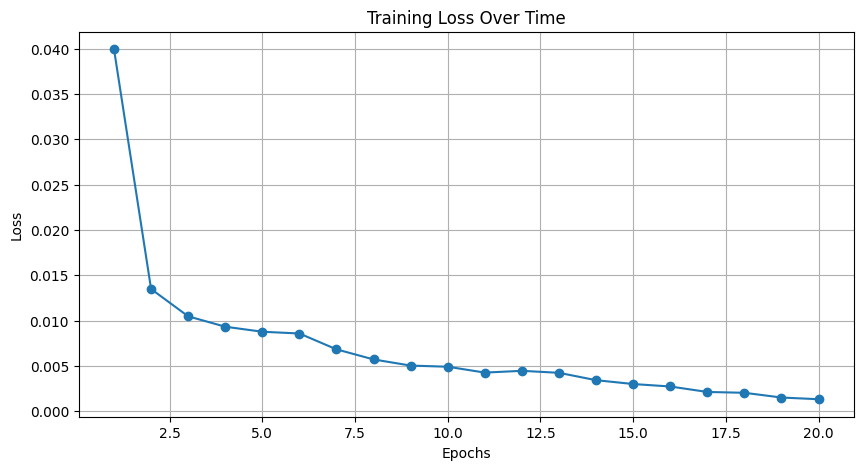

In [277]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses, marker="o", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.show()


In [278]:
def recommend_items(user_id, top_k=5):
    user_id_lower = user_id.strip().lower()  # Ensure case-insensitive matching
    
    if user_id_lower not in user_embeddings:
        print(f"User {user_id} not found!")
        return None
    
    user_emb = user_embeddings[user_id_lower].unsqueeze(0)
    scores = torch.cosine_similarity(model.user_tower(user_emb), model.item_tower(item_embeddings), dim=1)

    # Convert scores to a Pandas series for indexing
    scores_df = pd.Series(scores.detach().cpu().numpy(), index=df_items.index)

    # Debugging: Check if user's self-added items exist in the index
    if user_id_lower in user_added_items:
        to_remove = list(user_added_items[user_id_lower])
        print(f"🔹 Excluding self-added items for {user_id}: {to_remove}")
        scores_df = scores_df.drop(to_remove, errors="ignore")

    # Get top-k recommendations
    top_k_items = scores_df.nlargest(top_k).index
    return df_items.loc[top_k_items, ["brand", "name", "image_path"]]


In [279]:
def show_recommendations(user_id, top_k=5):
    recommendations = recommend_items(user_id, top_k)
    
    if recommendations is None or recommendations.empty:
        print(f"❌ No recommendations found for User: {user_id}")
        return
    
    print(f"\n🔹 Top-{top_k} Recommendations for User: {user_id}\n")
    
    fig, axes = plt.subplots(1, top_k, figsize=(15, 5))

    for i, (_, row) in enumerate(recommendations.iterrows()):
        img_path = row["image_path"]
        
        if os.path.isfile(img_path):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"{row['brand']}\n{row['name']}", fontsize=10)
            axes[i].axis("off")
        else:
            axes[i].set_title("Image Not Found", fontsize=10)
            axes[i].axis("off")

    plt.show()



🔹 Top-5 Recommendations for User: matt



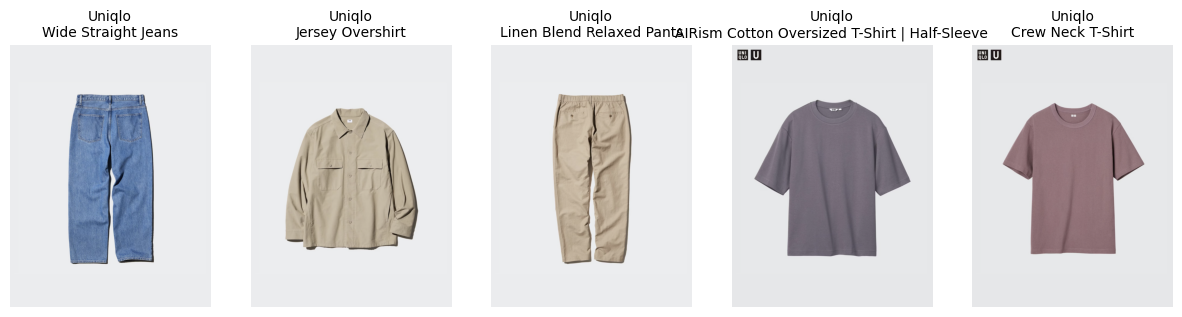


🔹 Top-5 Recommendations for User: laura



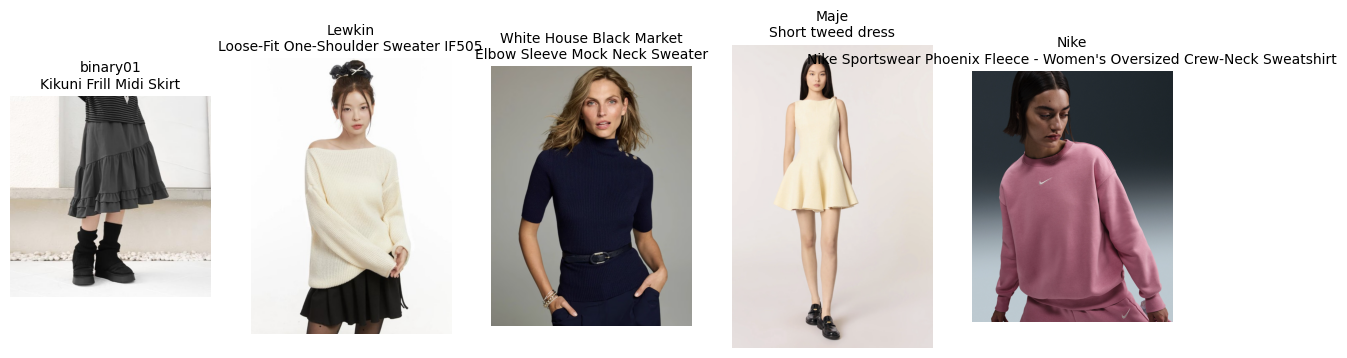


🔹 Top-5 Recommendations for User: megan



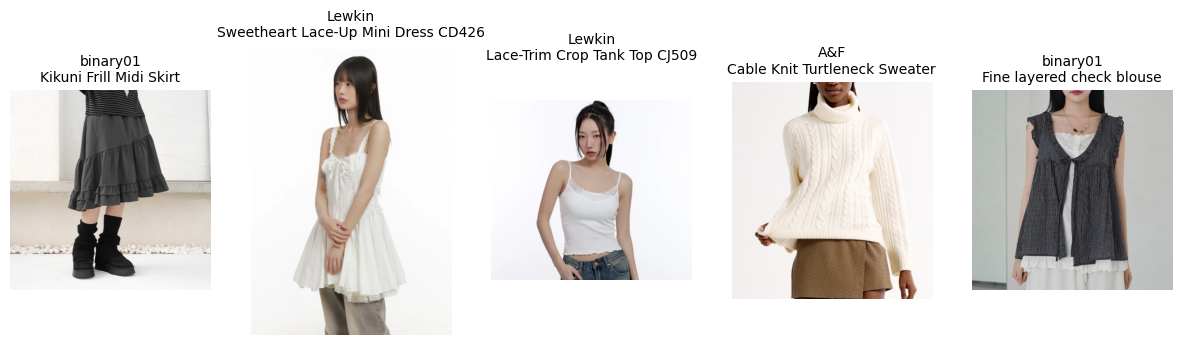


🔹 Top-5 Recommendations for User: vivian



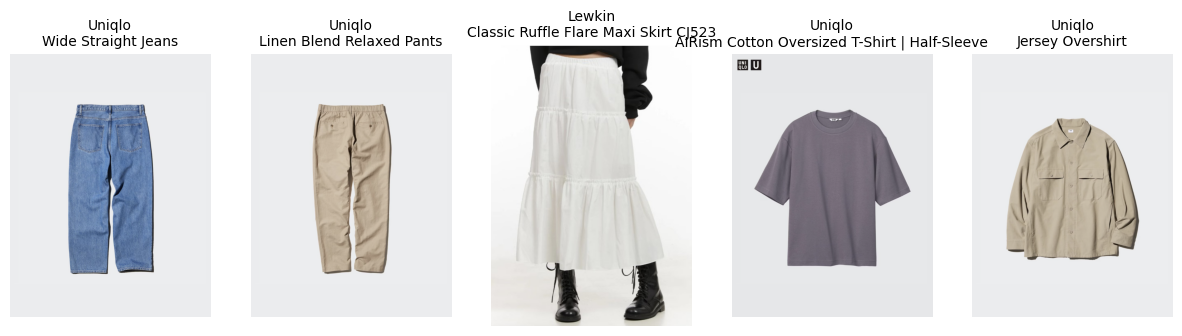


🔹 Top-5 Recommendations for User: brianna



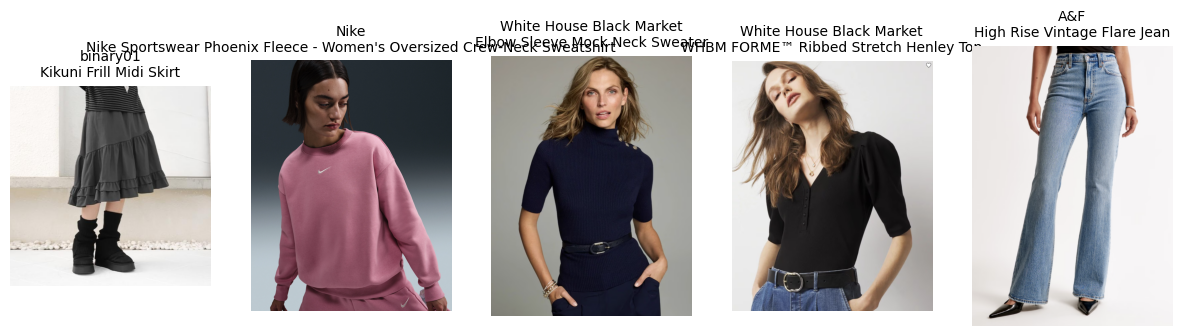


🔹 Top-5 Recommendations for User: sophia



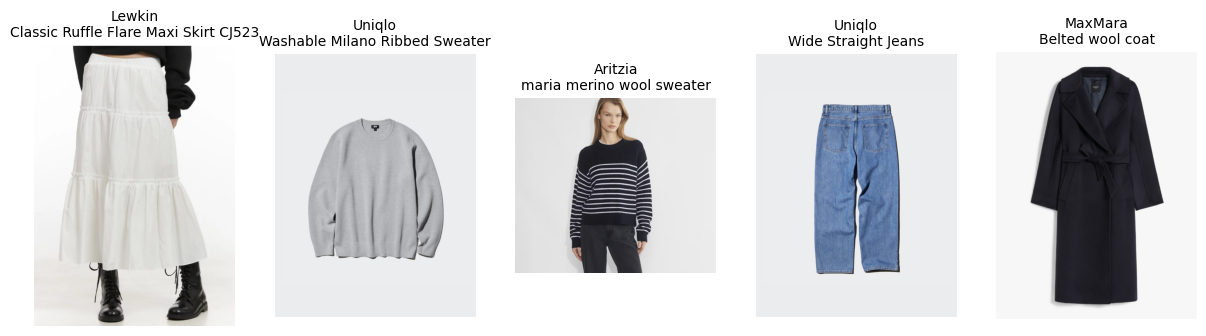


🔹 Top-5 Recommendations for User: jake



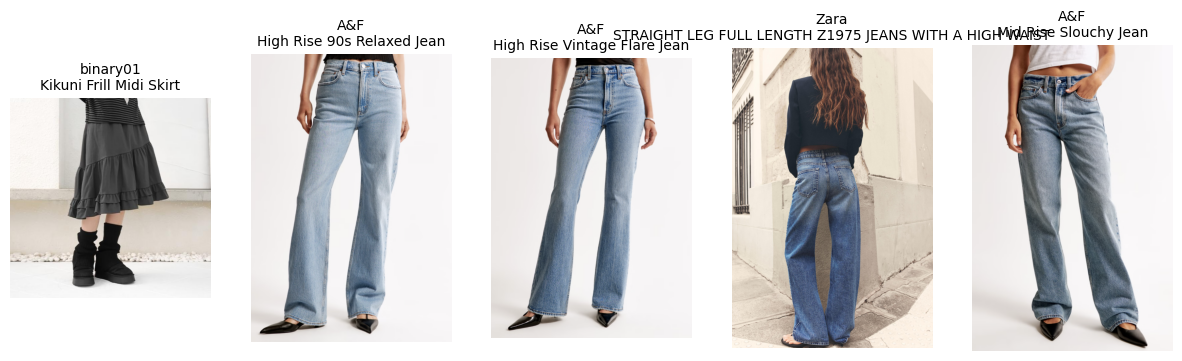


🔹 Top-5 Recommendations for User: lily



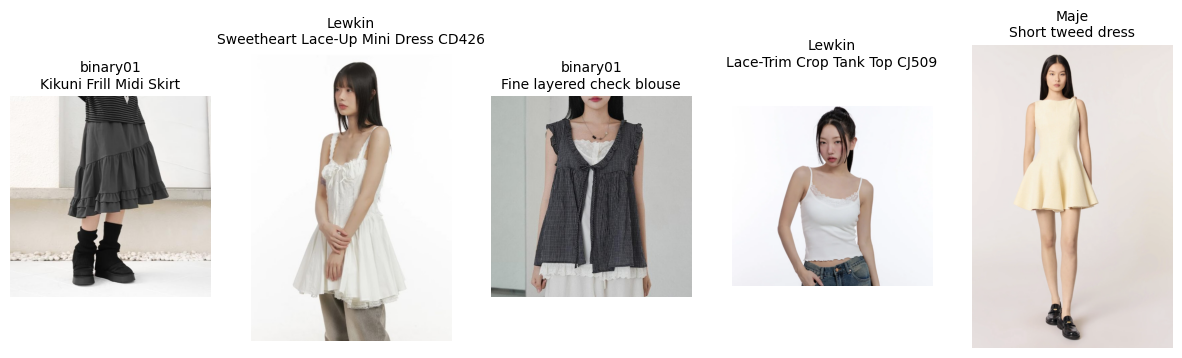


🔹 Top-5 Recommendations for User: alex



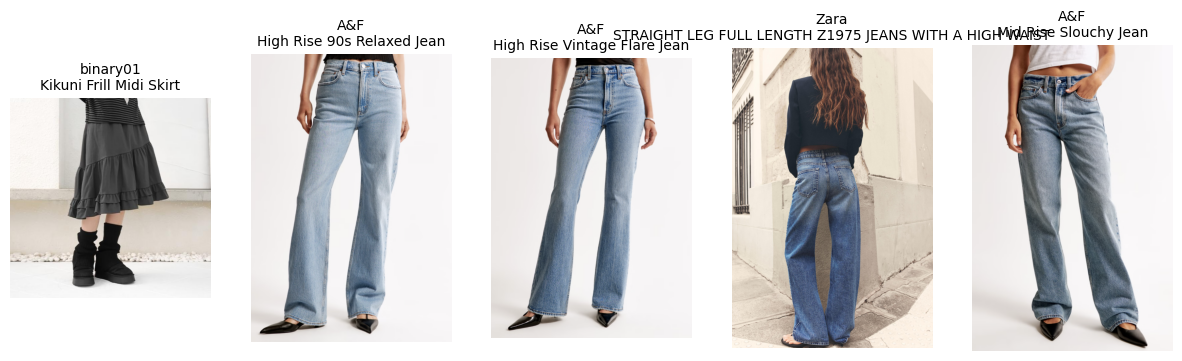


🔹 Top-5 Recommendations for User: emma



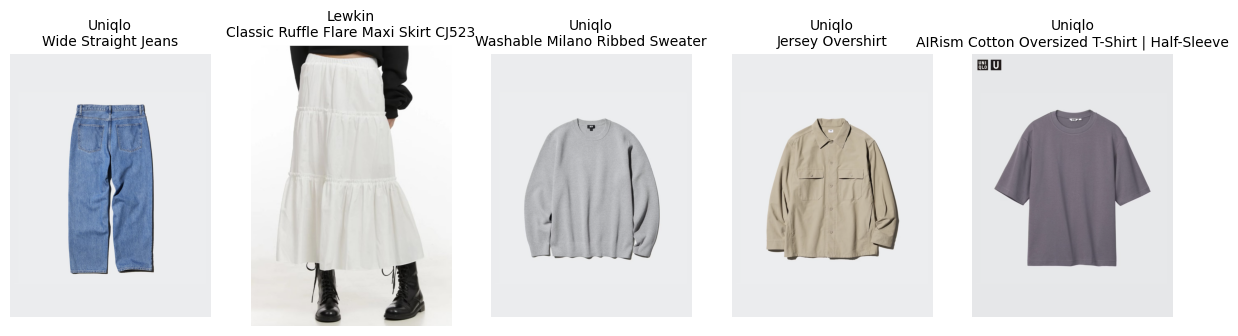


🔹 Top-5 Recommendations for User: user



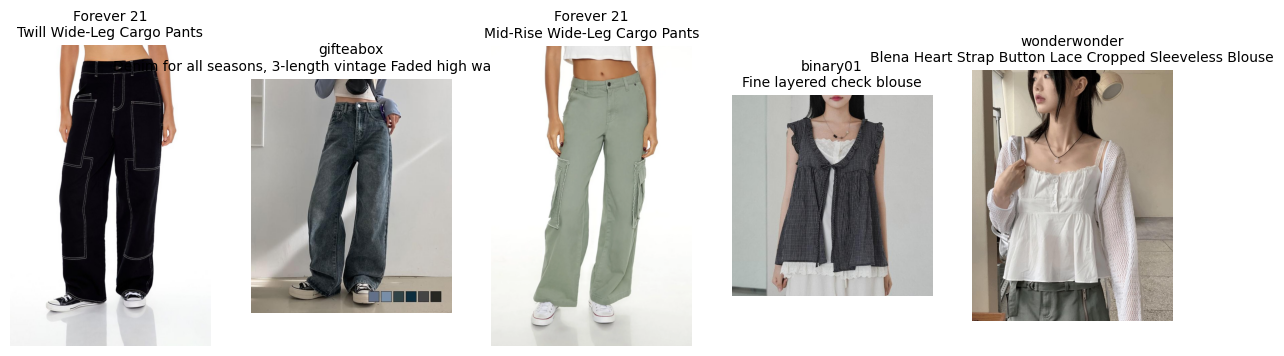

In [280]:
for user_id in df_ratings.columns:
    show_recommendations(user_id, top_k=5)
